# 【第３回 課題5　解答シート】 画像変換(2): CycleGAN
解答用のシートです．解答はこちらを改変して行って下さい．　

In [15]:
# UEC 共通設定
import os
# CED/IEDでの proxy の設定．
# keras.datasetsやkeras.applicationsでは，dataset, pretrained modelを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"      # "0":GPU0,..., "7":GPU7 を使用

# CED/IEDを自動判定して，datadir をセット．
cdir=os.getcwd()
if '/IED_HOME/' in cdir or '/.ced_ubuntu/' in cdir:
    datadir="/ced-home/staff/yanai/media/"
else: 
    datadir="/usr/local/class/object/media/"

if '/yanai/' in cdir:
    datadir="/export/space/yanai/media/"

### 食事相互変換実験

では，curry - rice のような変換をしてみましょう．

23種類から任意の２つを選んで試してみましょう．

In [16]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [17]:
# This code is based on https://github.com/eriklindernoren/Keras-GAN
from __future__ import print_function, division
import scipy

import keras
from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import time
import matplotlib.pyplot as plt
import sys
from data_loader_cy import DataLoader
import numpy as np
import os

In [24]:
# Input shape
img_size = 128
img_shape = (img_size, img_size, 3)

food_A="hiyachu"  # domain A のカテゴリ
food_B="gratin"  # domain B のカテゴリ

# Configure data loader
data_loader = DataLoader(datadir+"foodimg"+str(img_size),food_A,food_B,img_res=(img_size, img_size))

# Calculate output shape of D (PatchGAN)
patch = int(img_size / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 32
df = 64

outdir='result/cycle_1/'
os.makedirs(outdir, exist_ok=True)

epochs=50  # うまく変換できない場合は epochs=100 としてみてください．
batch_size=64
sample_interval=200

In [25]:
def build_generator():
    """U-Net Generator"""

    def conv2d(layer_input, filters, f_size=4):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        d = InstanceNormalization()(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = InstanceNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u

    # Image input
    d0 = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(d0, gf)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)

    # Upsampling
    u1 = deconv2d(d4, d3, gf*4)
    u2 = deconv2d(u1, d2, gf*2)
    u3 = deconv2d(u2, d1, gf)
    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(d0, output_img)

In [26]:
def build_discriminator():

    def d_layer(layer_input, filters, f_size=4, normalization=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d

    img = Input(shape=img_shape)

    d1 = d_layer(img, df, normalization=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, validity)

In [27]:
# Loss weight
lambda_cycle = 10.0                    # Cycle-consistency loss
lambda_id = 0.1 * lambda_cycle    # Identity loss

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminators
d_A = build_discriminator()
d_B = build_discriminator()
d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

#-------------------------
# Construct Computational
#   Graph of Generators
#-------------------------

# Build the generators
g_AB = build_generator()
g_BA = build_generator()

# Input images from both domains
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# Translate images to the other domain
fake_B = g_AB(img_A)
fake_A = g_BA(img_B)
# Translate images back to original domain
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)
# Identity mapping of images
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

# For the combined model we will only train the generators
d_A.trainable = False
d_B.trainable = False

# Discriminators determines validity of translated images
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

# Combined model trains generators to fool discriminators
combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            lambda_cycle, lambda_cycle,
                                            lambda_id, lambda_id ],
                            optimizer=optimizer)

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

def sample_images(epoch, batch_i):
    #os.makedirs('images/%s' % dataset_name, exist_ok=True)
    r, c = 3, 6

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r,c, figsize=(12,6))
    cnt = 0
    for i in range(r):
        imgs_A = data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Translate images to the other domain
        fake_B = g_AB.predict(imgs_A)
        fake_A = g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = g_BA.predict(fake_B)
        reconstr_B = g_AB.predict(fake_A)
    

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        cnt=0
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].set_title(titles[j%3])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("%s/%d_%d.png" % (outdir, epoch, batch_i))
    display.clear_output(wait = True)
    display.display(fig)
    plt.close()

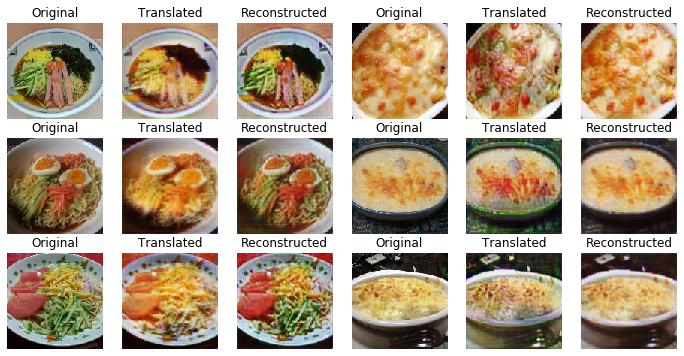

[Epoch 49/50] [Batch 5/15] [D loss: 0.247186, acc:  59%] [G loss: 4.058664, adv: 0.527218, recon: 0.133517, id: 0.180068] time: 1323 
[Epoch 49/50] [Batch 10/15] [D loss: 0.225947, acc:  64%] [G loss: 3.882391, adv: 0.522832, recon: 0.124993, id: 0.180825] time: 1333 


In [29]:
start = time.time()

# Adversarial loss ground truths
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

for epoch in range(epochs):
    for batch_i, (imgs_A, imgs_B) in enumerate(data_loader.load_batch(batch_size)):
        # ----------------------
        #  Train Discriminators
        # ----------------------

        # Translate images to opposite domain
        fake_B = g_AB.predict(imgs_A)
        fake_A = g_BA.predict(imgs_B)

        # Train the discriminators (original images = real / translated = Fake)
        dA_loss_real = d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = d_A.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = d_B.train_on_batch(fake_B, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        # Total disciminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)

        # ------------------
        #  Train Generators
        # ------------------

        # Train the generators
        g_loss = combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

        tm = time.time() - start

         # Plot the progress
        if batch_i % 5==0:
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %d " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            tm))

                # If at save interval => save generated image samples
        if batch_i % sample_interval == 0:
            sample_images(epoch, batch_i)

In [26]:
g_AB.save('%s/gen_%s2%s.h5' % (outdir,food_A,food_B))
g_BA.save('%s/gen_%s2%s.h5' % (outdir,food_B,food_A))
print("saved the models as '%s/gen_%s2%s.h5' and '%s/gen_%s2%s.h5'" % (outdir,food_A,food_B,outdir,food_B,food_A))

saved the models as 'result/cycle_1//gen_hiyachu2gratin.h5' and 'result/cycle_1//gen_gratin2hiyachu.h5'


## 課題５　

以下の小問の(1)(2)を解答せよ．

1. 23種類の中から好きな料理を２つ選んで食事画像変換モデルを学習せよ．64x64の場合は30分程度で学習できる．
1. 選んだ2種類の料理カテゴリの(学習に使っていない)自分で探した画像をそれぞれ5枚ずつ用意して変換してみよ．変換方法は，課題４の最後の学習済モデルからの画像生成を参考にせよ．

# (1) 23種類の中から好きな料理を２つ選んで食事画像変換モデルを学習せよ．64x64の場合は30分程度で学習できる．

# コメント

結果は上のようになった。Reconstructedが上手にできている一方で、Translatedは確かに変換できているのはわかるが、具材の色が変化しているというような、地味な変換になっていると感じた。ただ、初回で割と上手にできているので課題4までの内容に比べたら変換という処理は学習が少なくて済む内容なのだと考えられる。

# (2) 選んだ2種類の料理カテゴリの(学習に使っていない)自分で探した画像をそれぞれ5枚ずつ用意して変換してみよ．変換方法は，課題４の最後の学習済モデルからの画像生成を参考にせよ．

# 冷やし中華 $\rightarrow$ グラタン

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


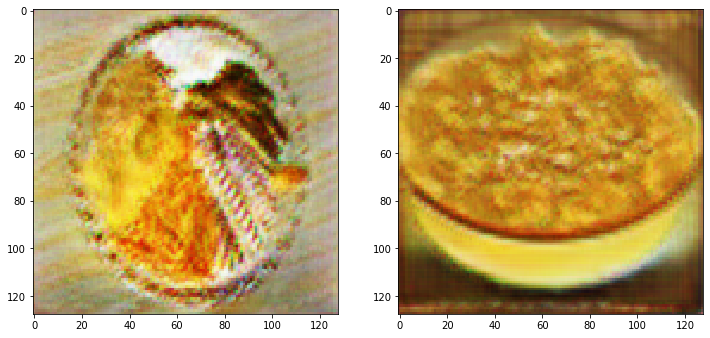

In [6]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model

generator=load_model('result/cycle_1//gen_hiyachu2gratin.h5')

img21=np.array(Image.open('img/hiyachu1.jpeg').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/gratin1.jpeg').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# グラタン $\rightarrow$ 冷やし中華

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


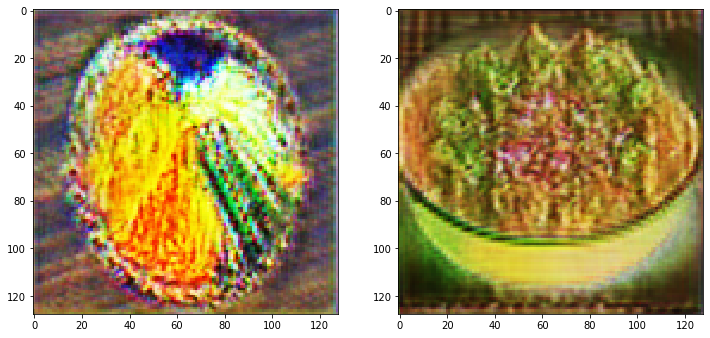

In [8]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model

generator=load_model('result/cycle_1//gen_gratin2hiyachu.h5')

img21=np.array(Image.open('img/hiyachu1.jpeg').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/gratin1.jpeg').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# 冷やし中華 $\rightarrow$ グラタン

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


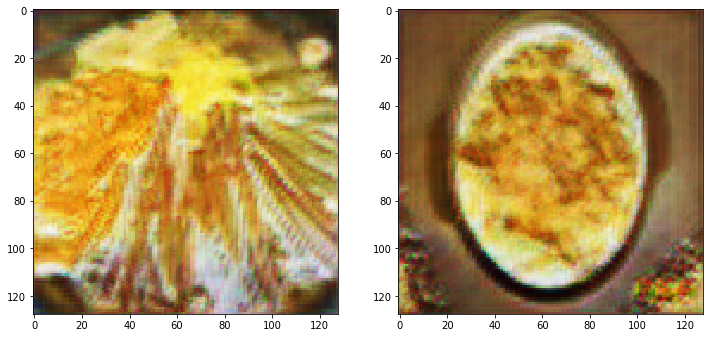

In [14]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model

generator=load_model('result/cycle_1//gen_hiyachu2gratin.h5')
#generator=load_model('result/cycle_1//gen_gratin2hiyachu.h5')
img21=np.array(Image.open('img/hiyachu2.jpeg').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/gratin2.jpeg').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# グラタン $\rightarrow$ 冷やし中華

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


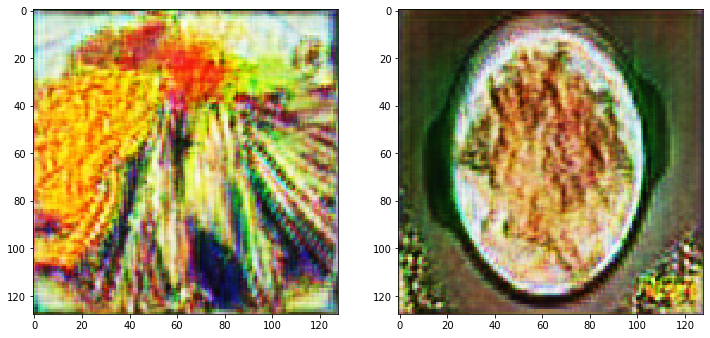

In [9]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model

generator=load_model('result/cycle_1//gen_gratin2hiyachu.h5')

img21=np.array(Image.open('img/hiyachu2.jpeg').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/gratin2.jpeg').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# 冷やし中華 $\rightarrow$ グラタン

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


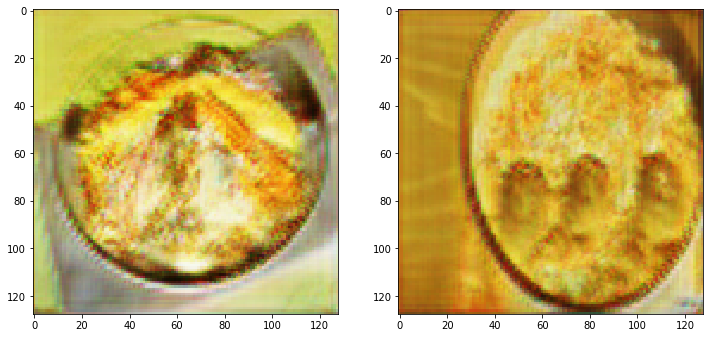

In [30]:
generator=load_model('result/cycle_1//gen_hiyachu2gratin.h5')
#generator=load_model('result/cycle_1//gen_gratin2hiyachu.h5')
img21=np.array(Image.open('img/hiyachu3.jpeg').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/gratin3.jpeg').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# グラタン $\rightarrow$ 冷やし中華

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


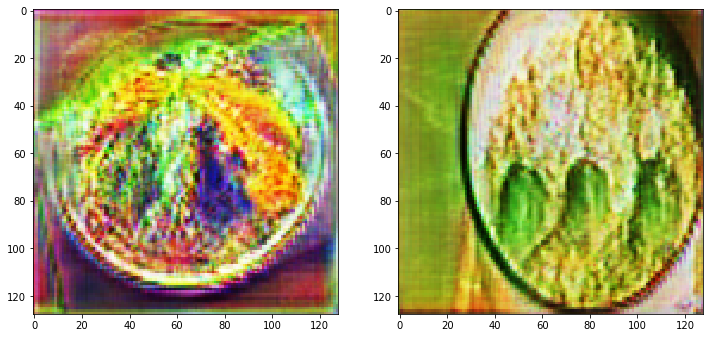

In [10]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model

generator=load_model('result/cycle_1//gen_gratin2hiyachu.h5')

img21=np.array(Image.open('img/hiyachu3.jpeg').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/gratin3.jpeg').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# 冷やし中華 $\rightarrow$ グラタン

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


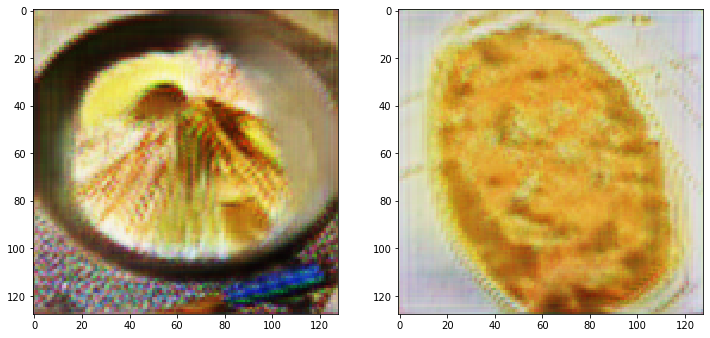

In [31]:
generator=load_model('result/cycle_1//gen_hiyachu2gratin.h5')
#generator=load_model('result/cycle_1//gen_gratin2hiyachu.h5')
img21=np.array(Image.open('img/hiyachu4.jpeg').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/gratin4.jpeg').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# グラタン $\rightarrow$ 冷やし中華

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


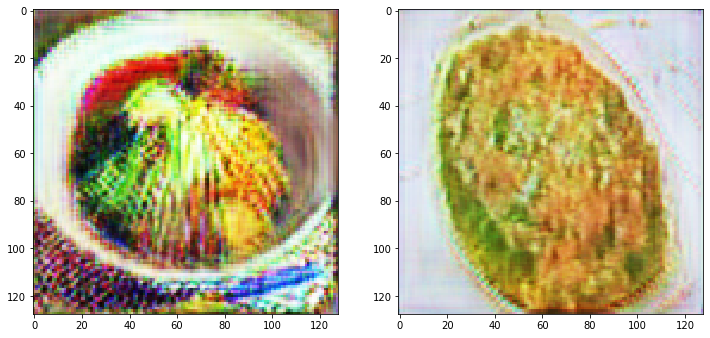

In [11]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model

generator=load_model('result/cycle_1//gen_gratin2hiyachu.h5')

img21=np.array(Image.open('img/hiyachu4.jpeg').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/gratin4.jpeg').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# 冷やし中華 $\rightarrow$ グラタン

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


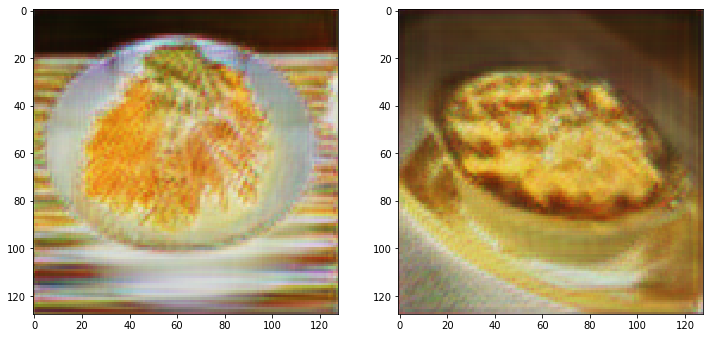

In [32]:
generator=load_model('result/cycle_1//gen_hiyachu2gratin.h5')
#generator=load_model('result/cycle_1//gen_gratin2hiyachu.h5')
img21=np.array(Image.open('img/hiyachu5.jpeg').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/gratin5.jpeg').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# グラタン $\rightarrow$ 冷やし中華

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


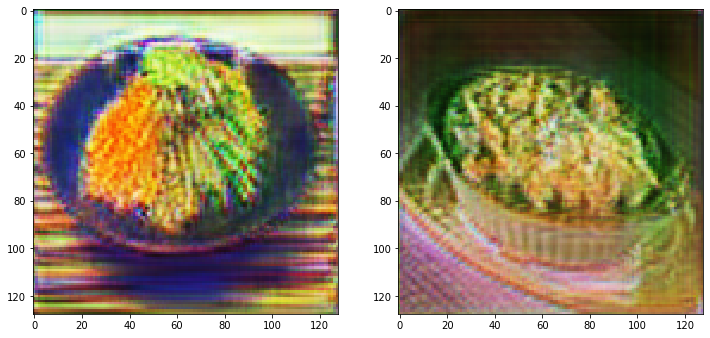

In [12]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model

generator=load_model('result/cycle_1//gen_gratin2hiyachu.h5')

img21=np.array(Image.open('img/hiyachu5.jpeg').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/gratin5.jpeg').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# コメント
冷やし中華からグラタンへの変換は割とうまくいっているように感じるが、グラタンから冷やし中華への変換の方はなんだかよくわからない結果になっている。最後の変換に関しては、グラタンに足のようなものが生えて、4本足の蜘蛛のようになっている。グラタン$\rightarrow$グラタンは少しぼやけているぐらいで違和感のないものに仕上がっているが、冷やし中華$\rightarrow$冷やし中華は明らかにおかしくなっている。これの原因であるが、冷やし中華からグラタンへの変換がカラフルなものを色の少ないものにする(色を少なくする)ものであるのに対し、グラタンから冷やし中華への変換が、色の少ないものをカラフルなものにする(色を多くする)ものであるからだと考えられる。つまり、冷やし中華からグラタンへの変換は色の違いを分かりにくくするものであるのに対し、グラタンから冷やし中華への変換は色の違いをより明確にするものであるということである。これによって、元からカラフルであった冷やし中華の色がさらに分割されたことで、上記の結果のようになったのだと考えられる。

In [33]:
# GPUメモリの開放
from numba import cuda
cuda.select_device(0)
cuda.close()